In [1]:
import pandas as pd
import numpy as np
from spacy.en import English
nlp = English()
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import matplotlib.pyplot as plt
%matplotlib inline

import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, tweet_content, cleaned_tweet from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)

In [2]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [13]:
def tweets_event_ab_test(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True)
    A1_vec = np.array([nlp(i).vector for i in A1['cleaned_tweet']])
    
    A2 = event_tweet.iloc[A_index,:] 
    A2.reset_index(inplace = True)
    A2_vec = np.array([nlp(i).vector for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1.reset_index(inplace = True)
    B1_vec = np.array([nlp(i).vector for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2.reset_index(inplace = True)
    B2_vec = np.array([nlp(i).vector for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.average(A1_vec, axis=0)
    A2_vec_mean = np.average(A2_vec, axis=0)
    B1_vec_mean = np.average(B1_vec, axis=0)
    B2_vec_mean = np.average(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',a1a2,'\n'
                'B1|B2: ',b1b2, '\n\n'
                'A1|B1: ',a1b1, '\n'
                'A2|B2: ', a2b2, '\n\n'
                'Cosine Similarity Mean of A2 to A1', a2_mean, '\n'
                'Cosine Similarity Mean of B2 to B1', b2_mean, '\n'
                'Cosine Similarity Mean of B2 to A1', a1b2_mean, '\n\n'
                'Cosine Similarity STD of A2 to A1', a2_std, '\n'
                'Cosine Similarity STD of B2 to B1', b2_std, '\n'
                'Cosine Similarity STD of B2 to A1', a1b2_std, '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [35]:
def Top_scored_tweets_in_B(event, n = 10000):
    event = event.lower()
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop = True)
    A_vec = np.array([nlp(i).vector for i in A['cleaned_tweet']])
    A_vec_mean = np.average(A_vec, axis=0)
    
    
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B.reset_index(inplace = True, drop = True)
    
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop = True)
    B1_vec = np.array([nlp(i).vector for i in B1['cleaned_tweet']])
    
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    print(result.shape)
    cluster = result[result['score']>.95]
    cluster.sort_values('score', ascending = False,inplace = True)
    return cluster.head(20)

Event Tweets (paris|climate):  2546
A1|A2:  0.999808 
B1|B2:  0.99947 

A1|B1:  0.972629 
A2|B2:  0.974946 

Cosine Similarity Mean of A2 to A1 0.896846 
Cosine Similarity Mean of B2 to B1 0.838332 
Cosine Similarity Mean of B2 to A1 0.819692 

Cosine Similarity STD of A2 to A1 0.089079 
Cosine Similarity STD of B2 to B1 0.144231 
Cosine Similarity STD of B2 to A1 0.147827 



(-0.1, 1)

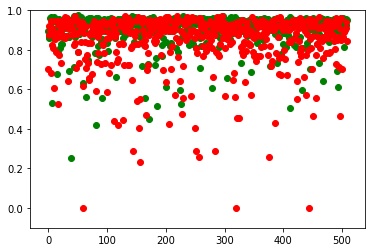

In [15]:
print('Event Tweets (paris|climate): ', event_tweet_count('paris|climate'))
A, B = tweets_event_ab_test('paris|climate')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1)

Event Tweets (nbafinals):  1120
A1|A2:  0.999628 
B1|B2:  0.998951 

A1|B1:  0.940789 
A2|B2:  0.944012 

Cosine Similarity Mean of A2 to A1 0.878789 
Cosine Similarity Mean of B2 to B1 0.822529 
Cosine Similarity Mean of B2 to A1 0.783197 

Cosine Similarity STD of A2 to A1 0.0772356 
Cosine Similarity STD of B2 to B1 0.184495 
Cosine Similarity STD of B2 to A1 0.16715 



(-0.1, 1.2)

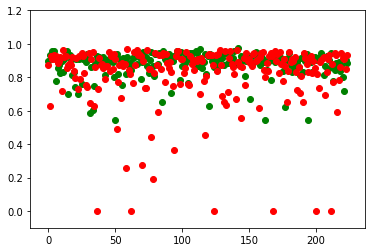

In [16]:
print('Event Tweets (nbafinals): ', event_tweet_count('nbafinals'))
A, B = tweets_event_ab_test('nbafinals')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

Event Tweets (travel ban|travelban):  199
A1|A2:  0.996951 
B1|B2:  0.992747 

A1|B1:  0.962097 
A2|B2:  0.96414 

Cosine Similarity Mean of A2 to A1 0.874697 
Cosine Similarity Mean of B2 to B1 0.801843 
Cosine Similarity Mean of B2 to A1 0.779817 

Cosine Similarity STD of A2 to A1 0.123912 
Cosine Similarity STD of B2 to B1 0.19948 
Cosine Similarity STD of B2 to A1 0.19824 



(-0.1, 1.2)

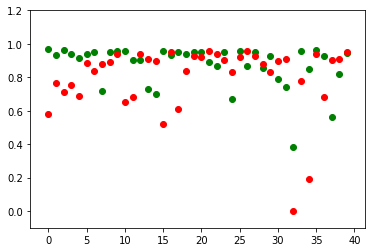

In [17]:
print('Event Tweets (travel ban|travelban): ', event_tweet_count('travel ban|travelban'))
A, B = tweets_event_ab_test('travel ban|travelban')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

Event Tweets (nationaldonutday):  527
A1|A2:  0.998209 
B1|B2:  0.99759 

A1|B1:  0.921144 
A2|B2:  0.916516 

Cosine Similarity Mean of A2 to A1 0.869883 
Cosine Similarity Mean of B2 to B1 0.836381 
Cosine Similarity Mean of B2 to A1 0.789729 

Cosine Similarity STD of A2 to A1 0.0643043 
Cosine Similarity STD of B2 to B1 0.124851 
Cosine Similarity STD of B2 to A1 0.105092 



(-0.1, 1.2)

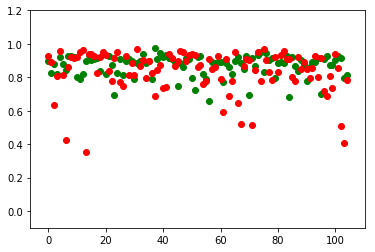

In [18]:
print('Event Tweets (nationaldonutday): ', event_tweet_count('nationaldonutday'))
A, B = tweets_event_ab_test('nationaldonutday')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [36]:
Top_scored_tweets_in_B('paris|climate', n = 15000)

(15000, 2)


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


score  \
2115   0.972668   
5282   0.972082   
8454   0.971221   
11626  0.967501   
3856   0.966892   
10437  0.966647   
179    0.966576   
9134   0.966342   
1223   0.966090   
11214  0.965310   
5228   0.965040   
13763  0.964966   
7306   0.964887   
3167   0.964403   
39     0.964104   
11081  0.963999   
4989   0.963954   
9440   0.963935   
9638   0.963921   
11152  0.963839   

                                                                                                                                              tweet  
2115                                 i'm proud to be a ca resident, ca leads the us and some of the world in pollution standards. we won't give up!  
5282                                        duh, what all of the news people have failed to recognize - a coup by trump and russia. if it doesn't…   
8454   roberts seems to have lost all faith in romo. if this wasn't the spot for him, i don't know what is. only dodger not to pitch in the series.  
11626      i'm sure a lot of people don't ask for fame. they seek it as regret it after a period of time. rappers especially, it's in their lyrics.  
3856                           this is making me feel less irate. end of the day however trump has 2 go. he's a menace and threatening not on the…   
10437       i don't even mind working all day. in order to get ahead in life you have to pay your dues! it's all apart of the process. trust in it.  
179                           actually, i'd take it outside the u.s. pretty sure he's in the top five for worst leaders of any country. ever. jfc.   
9134        being a man or a woman has nothing to do with #success or #power. both could reach the top of the world if they use their minds - s.ali  
1223                                     i do not get it. this show is so fucking important. money is not the issue, they have more of it than god.  
11214                                            many people left in this world, sad ! there is a saying: why is it always the good ones go first?   
5228        #mondaymotivation many of us lived through the bush years, even though we did not vote for him, without obstructing the gov't. why now?  
13763                                 it's up to individual states now, people have to lobby their reps. california is not going along with this!…   
7306   i just wish ppl would see whats in front of their eyes as real, believe it is real and work as hard as they can to fix it and make it better  
3167                                     a15: kinda reminds me of a man called 45. all that power and doesn't use it the right way. #mochagirlsread  
39       a lot of "don't say anything until we know the truth" re: london takes, which is prudent and cautious. but folks. uh. it's radical sunnis.  
11081                         ok people!! #rihanna isn't the first celeb to heckle a professional athlete and won't be the last. not breaking new…   
4989                                                    "this life is what you make it. no matter what, you're going to mess up sometimes, it's a…   
9440                                    set the tone for the day. start it with the belief that it will be the best day ever, and it just might be.  
9638                            with all that’s wrong with the world, i marvel that i get to go to this next week: blunt talk cannabis and design.   
11152                         never give up on what you really want to do. the person with big dreams is more powerful than one with all the facts.

In [37]:
Top_scored_tweets_in_B('nationaldonutday', n = 15000)

(15000, 2)


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


score  \
6163   0.966316   
12246  0.963995   
5639   0.962568   
4560   0.962019   
13833  0.961860   
10598  0.961555   
14600  0.961530   
9971   0.961356   
3075   0.960904   
163    0.959708   
13561  0.959616   
9410   0.958289   
5122   0.957928   
6178   0.957382   
9321   0.956624   
3553   0.956378   
7629   0.956321   
7880   0.956181   
5259   0.955245   
3134   0.955194   

                                                                                                                                        tweet  
6163                                looks like i will be giving &amp; their first facials this weekend! #welcometola #broday #gloupchallange   
12246                                        who is this guy? jrsilvas1 # #✅ #dj #chargedup came along way! #comeback story of a life time!…   
5639     i love how no one pays attention to me, even the people i love most. #donetalking #frustrated #jaded #noonegivesafuck #nobodylistens  
4560                                            who has the bet cats in the world? i do! #homesweethome #catsofinstagram #love #tripodkitty…   
13833                              found this crazy lily today, at least we think it's a lily 🤔. #westforksangabrielriver #stereoscopic #lsc   
10598              everyone shows up to the party, very few show up for preparation...- #onefelix 2017 #fruition #brickbybrick #listentofelix  
14600                      doing some more work today i had to get out! i have an awesome view #santamonica #mexicanfood #chillen #saturday…   
9971                                            i was never one to burn bridges...i'd rather run them! #runwiththewinners #nikerunning #nrc…   
3075                                          when you don't have a boyfriend but food will do! 🤗 . . . #blogger #yum #frozenyogurt #freeze…   
163                                   i'm in #brentwood enjoying an #americano a #croissant and a good #book i'm so #happy! #lifespleasures…   
13561                            we almost made it to the real line this time.... so close.... #guardiansofthegalaxy #gotg #missionbreakout…   
9410                                                       today is the day!! can't wait!!#lovemyjob #employeescreening #wblife #wonderwoman   
5122   thrilled #billmaher helped start this #nationaldialogueonrace! should white people say the n word on tv? let's talk it out! #notracist  
6178                                              dr. strangelove or: how i learned to stop worrying and love the #covfefe #ruinamovie #trump  
9321                                                    happy saturday to you all! #ramadankareem #holymonth  7840 firestone blvd,downey ca…   
3553                                                 now at a birthday party. how did they hijack our weekend?? #daddysboys #twins #dadlife…   
7629             #kevindurant is everywhere on defense. just like #romanreigns will need to be for #fatal5way match. #nbafinals #extremerules  
7880                                        hey, look at me! - the (real) caption for every #selfie ever #realtalk this is the new 'do post…   
5259                                       just hanging with #spidermanhomecoming looking for #happy because he is the cool one #jonfavreau…   
3134                                                                                                 it's #gametime w/ and i'm on #teamdubs.